We'll start by using the [markovify](https://github.com/jsvine/markovify/) library to make some social-media-sized utterances in the style of Jane Austen.  This will be the basis for generating a synthetic social media stream.

In [21]:
import markovify
import codecs

with codecs.open("austen.txt", "r", "cp1252") as f:
    text = f.read()

austen_model = markovify.Text(text)

for i in range(10):
    print(austen_model.make_short_sentence(200))

Her sorrow, her disappointment, her deep regret, when I take on my guard.
Men are very proud of him.
Some people call him earlier home.
There is not five minutes before she was so plain and her thoughts or fix her wedding-day--and Mr. Elton sauntering about.
The former she was sometimes quite provoked, but then she began her relation.
The anxieties of common occurrences with all her notions of what she could do nothing at all.
She had already mentioned their wishes and affection equally dictated, and I understand it now, and very kind reception of me which I last night to indulge them.
Elinor could hardly separate the parts, so as not unlikely that some pains are taken to prevent her from Barton.
They will have nothing clever to say--not one of the agitation which she had been made amiable himself; for he vowed he would have thought necessary.
Nothing could be three.


We'll use spaCy to identify entities (mostly proper nouns and noun phrases) in these synthetic status updates and turn them into hashtags:

In [58]:
import spacy
nlp = spacy.load('en')

def make_sentence(model, length=200):
    return model.make_short_sentence(length)
    
def hashtagify_full(sentence):
    doc = nlp(sentence)
    for ent in doc.ents:
        sentence = sentence.replace(str(ent), "#%s" % str(ent).replace(" ", ""))
    return (sentence, ["#%s" % str(ent).replace(" ", "") for ent in doc.ents])

def hashtagify(sentence):
    result,_ = hashtagify_full(sentence)
    return result

for i in range(5):
    sentence = make_sentence(austen_model)
    print(sentence)
    print(hashtagify(sentence))

But she would now be relinquished.
But she would now be relinquished.
I charged her to see him to stay, and in farther justification of Mr. Knightley, who had always been evident to her to talk.
I charged her to see him to stay, and in farther justification of Mr. #Knightley, who had always been evident to her to talk.
I am very miserable about you, and if she felt no restraint; and, with all the while, was most unlike Anne Elliot!
I am very miserable about you, and if she felt no restraint; and, with all the while, was most unlike #AnneElliot!
This was too impossible to explain away the first exclamations of her beauty and no embarrassment, at least as it did all for an indulgence was exciting even painful gratitude.
This was too impossible to explain away the #first exclamations of her beauty and no embarrassment, at least as it did all for an indulgence was exciting even painful gratitude.
On the contrary, when people are never allowed to be in no situation to have been done, even h

We'll now train two Markov models on positive and negative product reviews (taken from the [public-domain Amazon fine foods reviews dataset on Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews/)).  We'll incorporate the results of these models into our synthetic social media stream.

In [47]:
import gzip

def train_markov_gz(fn):
    """ trains a Markov model on gzipped text data """
    with gzip.open(fn, "rt", encoding="utf-8") as f:
        text = f.read()
    return markovify.Text(text)

negative_model = train_markov_gz("reviews-1.txt.gz")
positive_model = train_markov_gz("reviews-5-100k.txt.gz")

In [48]:
make_sentence(negative_model)

'This new formula other day -- GROSS!'

In [49]:
make_sentence(positive_model)

'She has trouble digesting kibble.'

We can combine these models with relative weights, but this yields somewhat unusual results:

In [54]:
compound_model = markovify.combine([austen_model, negative_model, positive_model], [14, 3, 3])

In [55]:
for i in range(20):
    print(hashtagify(make_sentence(compound_model)))

No bleeding, and no one will grab for these as a gift.
I can best describe as chewable cardboard.
We've tried it I would drink #about3-5minutes, then put over #250yearsold.
Sometimes I even reorded it ,it clogs my #Cuisinart k-cup brewer.I had the medium/large size, which is way too much coconut on the inside.
And so well supported her, but proud.
They also love that it gets here Wed.
They became lethargic and were in #Alaska for #manydays since I only hope that everyone has the best dessert .... fabulous fix for someone you know from this #3 cat household.
I love it and it went up #nearly$5dollars a jar of it ends up eating this microwavable meal.
This product is NOT the best brands I've seen, I could find on the approach of the premium beef taste that many parents and make you sweat... well, let's just say, DELICIOUS!!!! I bought it.
I highly recommend them to my pleasant surprise, given that the salsa would be another option.
Enjoy a cup of coffee in k-cups is typically added.
Item 

As is more or less the case in the real world, we'll assume that a small percentage of users are responsible for the bulk of social media activity, and that the bulk of users are responsible for relatively few posts.  We'll model this with a table of random user IDs that has a collection of relatively few talkative users and relatively many moderate users; the proportion of utterances from talkative users to utterances from moderate users is the inverse of the proportion of talkative users to moderate users.

In [137]:
import numpy
import math
import collections

class UserTable(object):
    def __init__(self, size, weights=[8, 2]):
        self._talkative = collections.deque()
        self._moderate = collections.deque()
        self._size = size
        self._cutoff = float(weights[0]) / sum(weights)
        
        for i in range(size):
            new_uid = math.floor(numpy.random.uniform(10 ** 10))
            if numpy.random.uniform() >= self._cutoff:
                self._moderate.append(new_uid)
            else:
                self._talkative.append(new_uid)
    
    def random_uid(self):
        def choose_from(c):
            return c[math.floor(numpy.random.uniform() * len(c))]
        
        if numpy.random.uniform() >= self._cutoff:
            return choose_from(self._talkative)
        else:
            return choose_from(self._moderate)
        

In [63]:
import seaborn

We can see the number of times each user ID appears if we ask the `UserTable` for 1000 random user IDs:

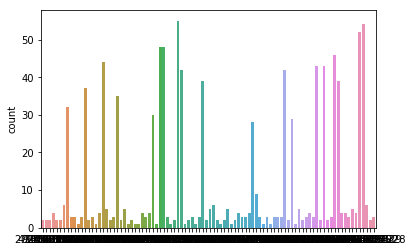

In [77]:
ut = UserTable(100)
uids = [ut.random_uid() for i in range(1000)]
seaborn.countplot(uids)

In [153]:
def generate_tweets(models, weights=None, hashtag_weights=[8, 2], ut=None, seed_hashtags=[]):
    if weights is None:
        weights = [1] * len(models)
    
    if ut is None:
        ut = UserTable(10000)
    
    choices = []
    
    total_weight = float(sum(weights))
    
    for i in range(len(weights)):
        choices.append((float(sum(weights[0:i+1])) / total_weight, models[i]))
    
    def choose_model():
        r = numpy.random.uniform()
        for (p, m) in choices:
            if r <= p:
                return m
        return choices[-1][1]
    
    seen_hashtags = set()
    hashtags = []
    total_hashtag_weight = float(sum(hashtag_weights))
    for i in range(len(hashtag_weights)): 
        hashtags.append((float(sum(hashtag_weights[0:i+1])) / total_hashtag_weight, collections.deque()))
    
    def choose_from(c):
        idx = math.floor(numpy.random.uniform() * len(c))
        return c[idx]
    
    def store_hashtag(tag):
        if tag not in seen_hashtags:
            seen_hashtags.add(tag)
            r = numpy.random.uniform()
            for(p, deq) in hashtags:
                if r <= p:
                    deq.append(tag)
    
    def choose_hashtag():
        r = numpy.random.uniform()
        for(p, deq) in hashtags:
            if r >= 1.0 - p:
                return choose_from(deq)
        return choose_from(hashtags[0][0])
    
    for tag in seed_hashtags:
        store_hashtag(tag)
    
    while True:
        tweet, tags = hashtagify_full(make_sentence(choose_model()))
        for tag in tags:
            store_hashtag(tag)
        
        this_tweet_tags = set([str(tag) for tag in tags])
        
        if len(seen_hashtags) > 0:
            for i in range(min(numpy.random.poisson(3), len(seen_hashtags))):
                tag = choose_hashtag()
                if str(tag) not in this_tweet_tags:
                    this_tweet_tags.add(str(tag))
                    tweet += " %s" % choose_hashtag()
            
        yield (ut.random_uid(), tweet)

In [154]:
t = generate_tweets([austen_model, positive_model, negative_model], [20, 3, 3], seed_hashtags=["#ff", "#followfriday", "#yolo", "#retweet", "#tbt"])

In [155]:
t

<generator object generate_tweets at 0x138edcf10>

In [156]:
[next(t) for i in range(10)]

[(5596972478,
  'For most people who do not need to feel like indulging in some way of getting the heavy cream, where the bad dog odor. #followfriday #ff #followfriday'),
 (5881866,
  'In his marrying #Lucy; that some excuse for drinking claret every day. #Lucy #Lucy'),
 (8450234992,
  'Colonel #Brandon left the room by his language or manners. #retweet'),
 (7887841568,
  'He is just as we might there converse with her, because her real eight-and-thirty. #yolo #ff'),
 (892109985,
  "You couldn't pay me to write about it is the product at any rate! #ff #ff #Lucy"),
 (6749041524, 'Then changed to cheaper ingredients. #yolo #Lucy #yolo'),
 (2798801545,
  'She will be the harm of him; I do not let us be frightened from paying him those attentions were her words. #tbt #yolo #followfriday'),
 (8732842453,
  'The spare rooms in the affair stood at the door, when a rap foretold a visitor, whom they had gained him in company with him to dinner, and therefore I hope he has amazing strong feeling